In [1]:
! wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
! tar -xzvf cifar-10-python.tar.gz
! rm cifar-10-python.tar.gz

--2023-06-02 11:30:29--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.5MB/s    in 11s     

2023-06-02 11:30:41 (14.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 0.8 * 15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
class CIFAR10_dataset():
  def __init__(self,root_dir,num_train = 50000,num_validation = 0,num_test= 10000,batch='entire'):
    self.root_dir = root_dir
    self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if(num_train > 50000):
      print("Max length of dataset is 50000")
      
    if(num_train + num_validation > 50000):
      print("SUM of training and validation datapoints cannot be more than 50000")
    else:
      self.numTrainSet = num_train
      self.numValidationSet = num_validation
      print(self.numValidationSet)
      self.numTestSet = num_test
      if(batch == 'entire'):
        self.load_entire_data()
      elif(batch <=5 or batch >=1):
        self.load_batch(batch)


  # HELPER FUNCTION : Loads a single batch of cifar data
  def __load_cifar_batch(self,filename):
    with open(filename,'rb') as f:
      raw_data = pickle.load(f,encoding="latin1")
      X= raw_data['data']
      y= raw_data['labels']
      X=np.array(X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float"))
      y = np.array(y)
      return X,y
  #Loads a single batch 
  def load_batch(self,batch_number):
    f = os.path.join(self.root_dir, "data_batch_%d" % (batch_number,))
    self.X,self.y = self.__load_cifar_batch(f)



  #Load entire CIFAR dataset(all batches)
  def load_entire_data(self,validationSet=False):
      xs = []
      ys = []
      for b in range(1, 6):
          f = os.path.join(self.root_dir, "data_batch_%d" % (b,))
          X, y = self.__load_cifar_batch(f)
          xs.append(X)
          ys.append(y)
      Xtr = np.concatenate(xs)
      Ytr = np.concatenate(ys)
      self.X_test, self.y_test = self.__load_cifar_batch(os.path.join(self.root_dir, "test_batch"))
      self.X_val,self.y_val = Xtr[range(self.numTrainSet,self.numTrainSet+self.numValidationSet)],Ytr[range(self.numTrainSet,self.numTrainSet+self.numValidationSet)]
      print(self.X_val.shape)
      self.X_train,self.y_train = Xtr[:self.numTrainSet],Ytr[:self.numTrainSet]
      self.getDimensions()

      

  def normalise(self):
    mean_image = np.mean(self.X_train, axis=0)
    self.X_train -= mean_image
    self.X_val -= mean_image
    self.X_test -= mean_image


  def standardize(self,axis=None):
    mean = np.mean(self.X_train, axis=axis, keepdims=True)
    std = np.sqrt(((self.X_train - mean)**2).mean(axis=axis, keepdims=True))
    self.X_train = (self.X_train - mean) / std
    mean = np.mean(self.X_val, axis=axis, keepdims=True)
    std = np.sqrt(((self.X_val - mean)**2).mean(axis=axis, keepdims=True))
    self.X_val = (self.X_val - mean) / std
    mean = np.mean(self.X_test, axis=axis, keepdims=True)
    std = np.sqrt(((self.X_test - mean)**2).mean(axis=axis, keepdims=True))
    self.X_test = (self.X_test - mean) / std
    

  # Visualize some examples from the dataset.
  # We show a few examples of training images from each class.
  def visualise(self,sample_size):
    num_classes = len(self.classes)
    samples_per_class = sample_size
    for y, cls in enumerate(self.classes):
        idxs = np.flatnonzero(self.y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(self.X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
  def getDimensions(self):
    print("Training data dimension: ",(self.X_train.shape,self.y_train.shape))  
    print("Validation data dimension: ",(self.X_val.shape,self.y_val.shape))
    print("Test data dimension: ",(self.X_test.shape,self.y_test.shape))

  def reshape(self):
    self.X_train = np.reshape(self.X_train,(self.X_train.shape[0],-1))
    self.X_val = np.reshape(self.X_val,(self.X_val.shape[0],-1))
    self.X_test = np.reshape(self.X_test,(self.X_test.shape[0],-1))
  def bias_trick(self):
    self.X_train = np.hstack([self.X_train,np.ones((self.X_train.shape[0],1))])
    self.X_val = np.hstack([self.X_val,np.ones((self.X_val.shape[0],1))])
    self.X_test = np.hstack([self.X_test,np.ones((self.X_test.shape[0],1))])


  



5000
(5000, 32, 32, 3)
Training data dimension:  ((45000, 32, 32, 3), (45000,))
Validation data dimension:  ((5000, 32, 32, 3), (5000,))
Test data dimension:  ((10000, 32, 32, 3), (10000,))
(45000, 32, 32, 3)


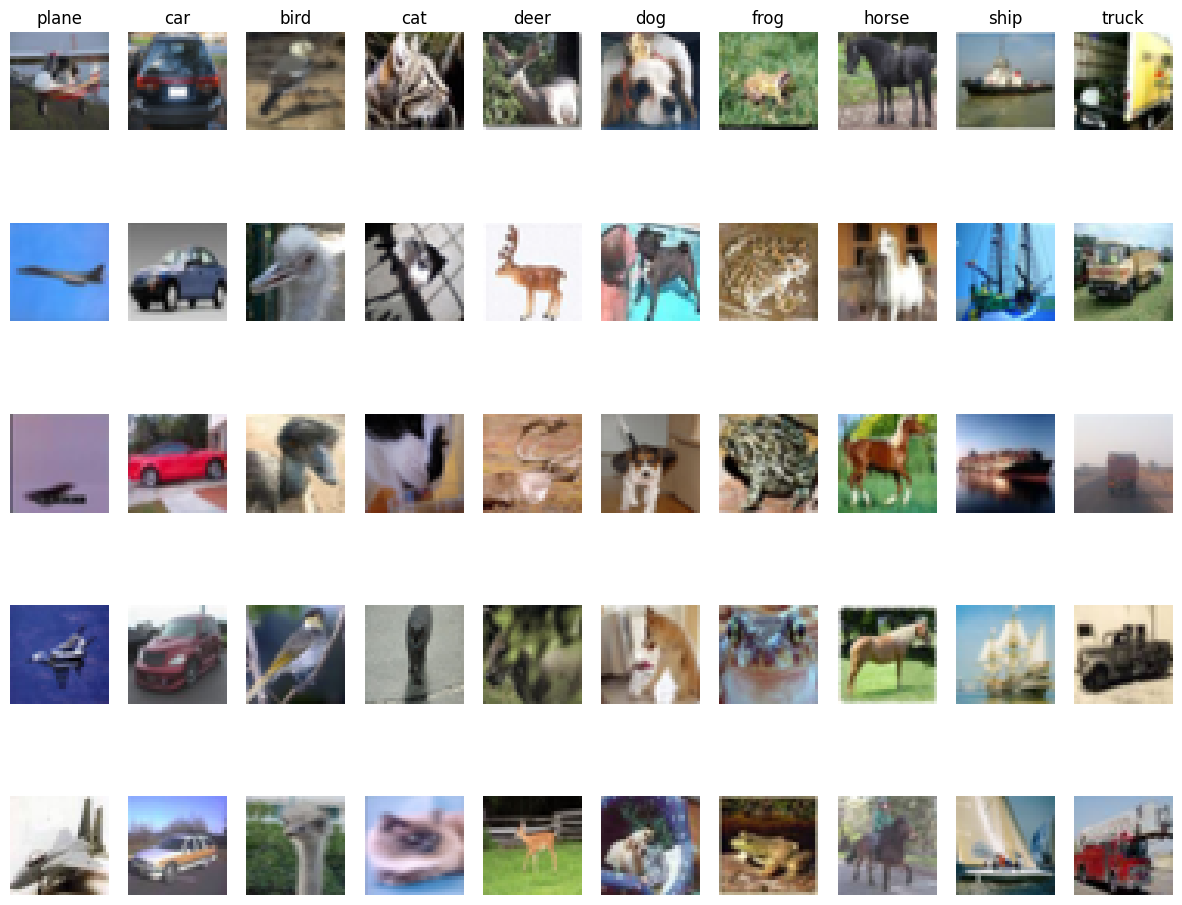

In [5]:
# CIFAR root dir
cifar10_dir = "/content/cifar-10-batches-py/"

dataset = CIFAR10_dataset(cifar10_dir,45000,5000,10000)
print(dataset.X_train.shape)
dataset.visualise(5)
dataset.reshape()
dataset.normalise()
dataset.bias_trick()




In [6]:
dataset.getDimensions()

Training data dimension:  ((45000, 3073), (45000,))
Validation data dimension:  ((5000, 3073), (5000,))
Test data dimension:  ((10000, 3073), (10000,))


In [7]:
class SVM():
  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # list of integers between 0 and length of X (these are our indices
    X_indices = np.arange(num_train)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None
      # Choose 'batch_size' random values from X_indices.
      batch_indices = np.random.choice(X_indices,batch_size)

      # Get our batch from these indices.
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # Gradient descent basic rule is just: weights += -(learning_rate * dW).
      self.W += -(learning_rate * grad)

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    y_pred = np.zeros(X.shape[0])
    pred_scores = np.dot(X,self.W)
    y_pred = np.argmax(pred_scores, axis=1)
    return y_pred
  def loss(self,X_batch,y_batch,reg):
    return self.svm_loss_vectorized(self.W,X_batch,y_batch,reg)

  def svm_loss_vectorized(self,W, X, y, reg):
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_train = X.shape[0]
    scores = np.dot(X, W)
    correct_class_scores = np.choose(y, scores.T)  # np.choose uses y to select elements from scores.T
    # Need to remove correct class scores as we dont calculate loss/margin for those.
    mask = np.ones(scores.shape, dtype=bool)
    mask[range(scores.shape[0]), y] = False
    scores_ = scores[mask].reshape(scores.shape[0], scores.shape[1]-1)
    # Calculate our margins all at once.
    margin = scores_ - correct_class_scores[..., np.newaxis] + 1
    # Only add margin to our loss if it's greater than 0, let's make
    # negative margins =0 so they dont change our loss.
    margin[margin < 0] = 0
    # Average our data loss over the size of batch and add reg. term to the loss.
    loss = np.sum(margin) / num_train
    loss += reg * np.sum(W * W)
    original_margin = scores - correct_class_scores[...,np.newaxis] + 1

    # Mask to identiy where the margin is greater than 0 (all we care about for gradient).
    pos_margin_mask = (original_margin > 0).astype(float)

    # Count how many times >0 for each image but dont count correct class hence -1
    sum_margin = pos_margin_mask.sum(1) - 1

    # Make the correct class margin be negative total of how many > 0
    pos_margin_mask[range(pos_margin_mask.shape[0]), y] = -sum_margin

    # Now calculate our gradient.
    dW = np.dot(X.T, pos_margin_mask)

    # Average over batch and add regularisation derivative.
    dW = dW / num_train + 2 * reg * W
    return loss, dW

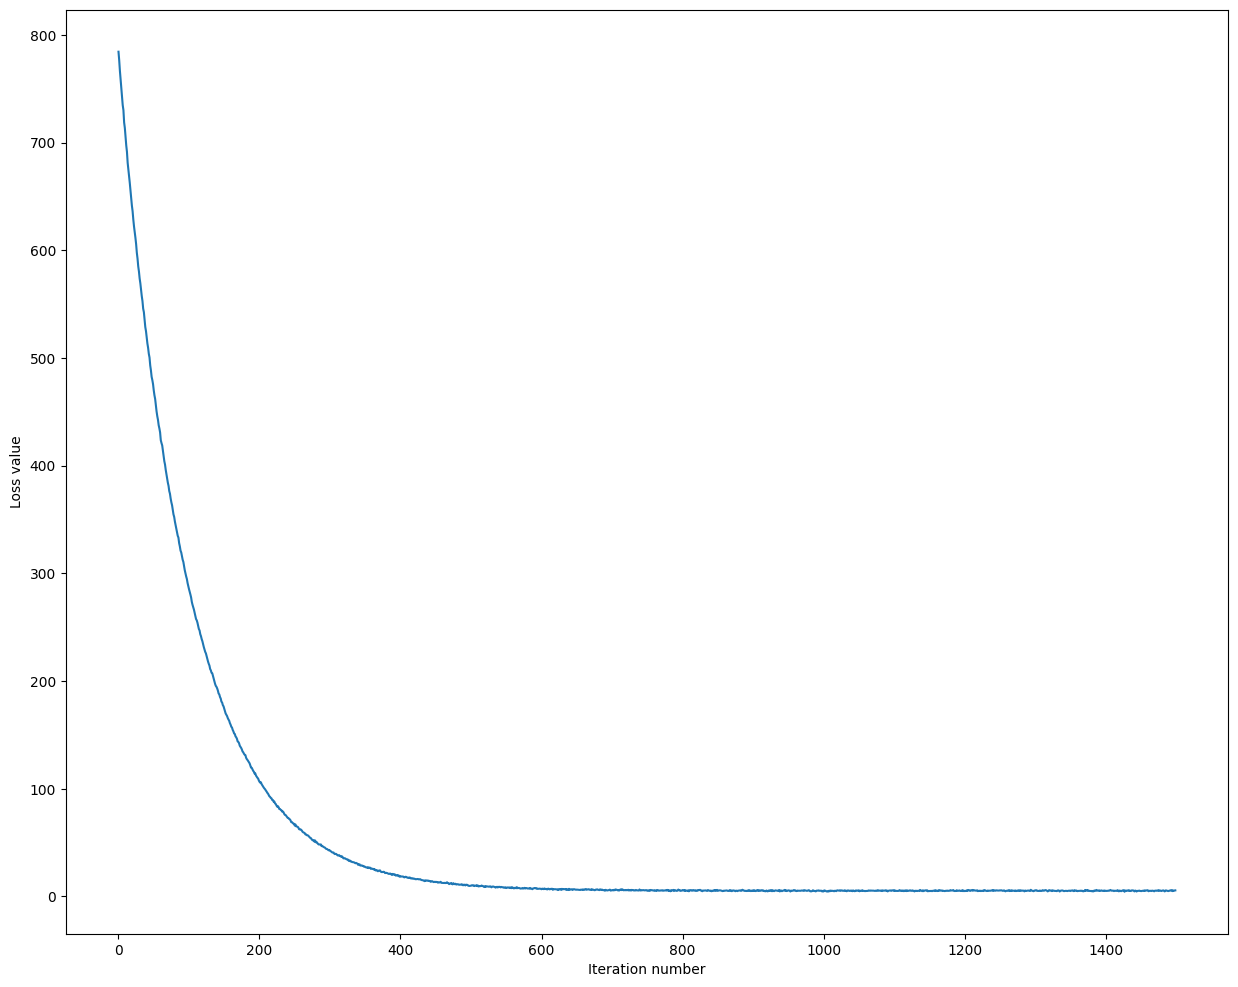

In [8]:
svm = SVM()
loss_history = svm.train(dataset.X_train,dataset.y_train,learning_rate=1e-7, reg=2.5e4,num_iters=1500)

plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
y_train_pred = svm.predict(dataset.X_train)
print('training accuracy: %f' % (np.mean(dataset.y_train == y_train_pred), ))
y_val_pred = svm.predict(dataset.X_val)
print('validation accuracy: %f' % (np.mean(dataset.y_val == y_val_pred), ))

training accuracy: 0.375289
validation accuracy: 0.366200


In [12]:
lr_rates=[1e-7,5e-5]
reg_strengths=[1.5e4,5e4]
results={}
best_val = -1
best_svm = None
for lr in np.linspace(lr_rates[0],lr_rates[1],3):
  for reg in np.linspace(reg_strengths[0],reg_strengths[1],3):
    svm = SVM()
    svm.train(dataset.X_train,dataset.y_train,learning_rate = lr,reg = reg,num_iters = 1500)
    y_train_pred = svm.predict(dataset.X_train)
    train_acc = np.mean(y_train_pred == dataset.y_train)

    y_val_pred = svm.predict(dataset.X_val)
    val_acc = np.mean(y_val_pred == dataset.y_val)
    results[(lr,reg)] = (train_acc,val_acc)
    if(val_acc > best_val):
      best_val = val_acc
      best_svm = svm

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
    


<ipython-input-7-cda5d707a583>:64: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-7-cda5d707a583>:64: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
<ipython-input-7-cda5d707a583>:58: RuntimeWarning: overflow encountered in subtract
  margin = scores_ - correct_class_scores[..., np.newaxis] + 1
<ipython-input-7-cda5d707a583>:65: RuntimeWarning: overflow encountered in subtract
  original_margin = scores - correct_class_scores[...,np.newaxis] + 1
<ipython-input-7-cda5d707a583>:58: RuntimeWarning: invalid value encountered in subtract
  margin = scores_ - correct_class_scores[..., np.newaxis] + 1
<ipython-input-7-cda5d707a583>:65: RuntimeWarning: invalid value encountered in subtract
  original_margin = scores - correct_class_score

lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.376156 val accuracy: 0.364800
lr 1.000000e-07 reg 3.250000e+04 train accuracy: 0.367311 val accuracy: 0.363600
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359600 val accuracy: 0.358200
lr 2.505000e-05 reg 1.500000e+04 train accuracy: 0.180622 val accuracy: 0.181800
lr 2.505000e-05 reg 3.250000e+04 train accuracy: 0.108533 val accuracy: 0.109800
lr 2.505000e-05 reg 5.000000e+04 train accuracy: 0.057578 val accuracy: 0.058200
lr 5.000000e-05 reg 1.500000e+04 train accuracy: 0.099622 val accuracy: 0.097800
lr 5.000000e-05 reg 3.250000e+04 train accuracy: 0.100156 val accuracy: 0.098600
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100156 val accuracy: 0.098600
best validation accuracy achieved during cross-validation: 0.364800


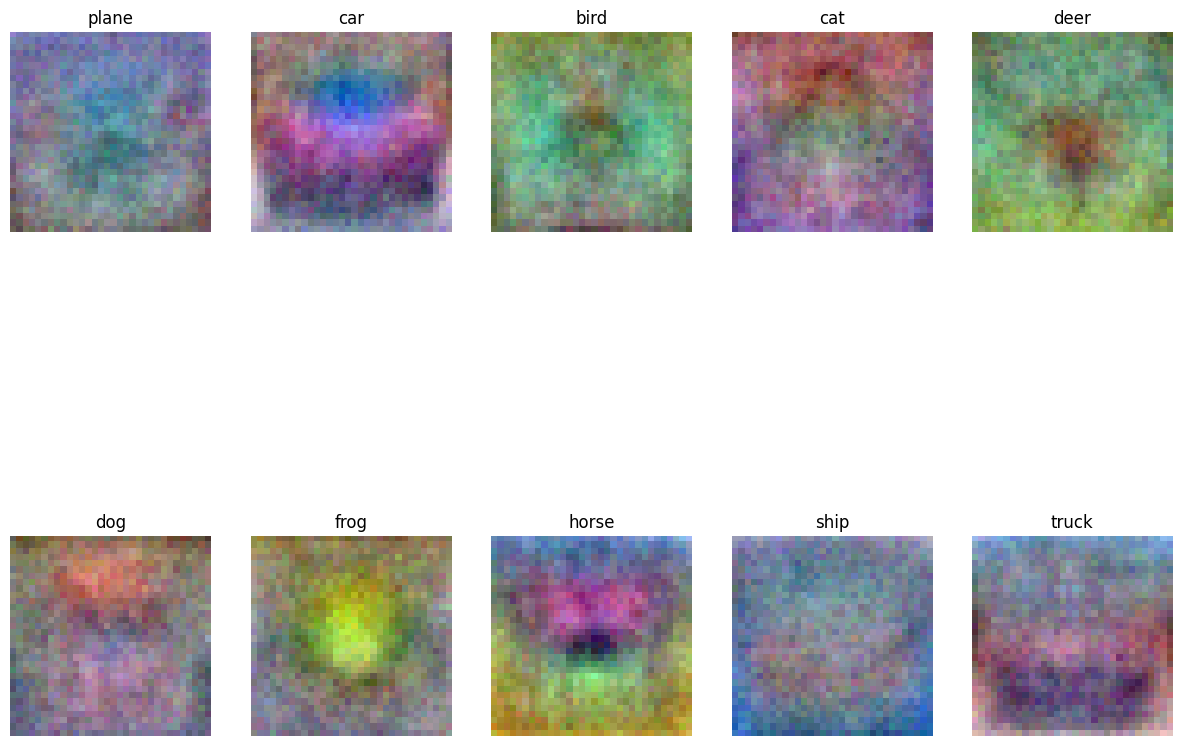

In [13]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])